In [207]:
import torch
from torch_geometric.data import Data
from itertools import combinations

def create_ingredient_graph(dishes, num_ingredients):
    """
    Create a co-occurrence graph for ingredients.

    Parameters:
    - dishes: List of dishes, each dish is a list of ingredient indices.
    - num_ingredients: Total number of ingredients.

    Returns:
    - graph: PyTorch Geometric Data object representing the graph.
    """
    # Initialize adjacency matrix
    adjacency_matrix = torch.zeros((num_ingredients, num_ingredients))

    # Fill adjacency matrix based on co-occurrences
    for dish in dishes:
        for i, j in combinations(dish, 2):  # combinations avoids self-loops and duplicates
            adjacency_matrix[i, j] += 1
            adjacency_matrix[j, i] += 1


    # Extract edges and edge weights
    edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()  # (2, num_edges)
    edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]     # (num_edges,)

    # Create node features (optional: identity matrix for simple embeddings)
    node_features = torch.eye(num_ingredients)

    # Create the PyTorch Geometric graph object
    graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight)

    return graph

train_ingr_id = './train_labels_ingr_id.csv'
# val_ingr_id = './val_labels_ingr_id.csv'
# test_ingr_id = './test_labels_ingr_id.csv'
import pandas as pd

train_df = pd.read_csv(train_ingr_id)
# val_df = pd.read_csv(val_ingr_id)
# test_df = pd.read_csv(test_ingr_id)

# combine the train, validation, and test DataFrames
# df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df = train_df

num_ingredients = len(df.columns) - 2  # Subtract 2 for 'dish_id' and 'image_path' columns

# df structure
# dish_id, ingredient 1, ingredient 2, ingredient 3, ingredient 4, ingredient 5, ingredient 6, ingredient 7, ingredient 8, ingredient 9, ingredient 10, ...
# x, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0
ingr_list = []
# for each dish, add the index of the ingredients where the value is 1 to the list
# e.g. dish_1 = [1, 3], dish_2 = [1, 4], dish_3 = [2, 3], ...
# ingr_list = [[1, 3], [1, 4], [2, 3], ...]
# Iterate over each row of the DataFrame
for _, row in df.iterrows():
    # We assume that the first column is 'dish_id' and the remaining columns represent ingredients.
    # Extract the values starting from the second column onward (i.e., ingredient columns)
    # last column is the image_path, so we exclude it
    ingredient_values = row.iloc[1:-1]
    
    # Find the indices (0-based) of the ingredients where the value is 1
    selected_indices = [i for i, val in enumerate(ingredient_values) if val == 1]
    
    # Append the list of selected ingredient indices for this dish
    ingr_list.append(selected_indices)

print(df.iloc[0])
# print the second row of the DataFrame
print(ingr_list[0])

id                       dish_1562699612
brown rice                           1.0
quinoa                               1.0
olive oil                            1.0
carrot                               0.0
                            ...         
chilaquiles                          0.0
pasta salad                          0.0
balsamic vinegar                     0.0
toast                                0.0
img_indx            dish_1562699612.jpeg
Name: 0, Length: 201, dtype: object
[0, 1, 2]


In [208]:
import numpy as np
adj_matrix = np.zeros((num_ingredients, num_ingredients), dtype=np.int32)

for dish in ingr_list:
    for i, j in combinations(dish, 2):
        adj_matrix[i, j] += 1
        adj_matrix[j, i] += 1

adj_matrix        


array([[  0,  11, 187, ...,   0,   0,   0],
       [ 11,   0, 119, ...,   0,   0,   0],
       [187, 119,   0, ...,   1,   1,   0],
       ...,
       [  0,   0,   1, ...,   0,   0,   0],
       [  0,   0,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [209]:
if np.allclose(adj_matrix, adj_matrix.T):
    print("The graph is undirected.")
else:
    print("The graph is directed.")


The graph is undirected.


In [210]:
threshold = 8

# convert adjacency matrix to PyTorch Geometric graph
edge_index = torch.tensor(np.where(adj_matrix >= threshold), dtype=torch.long)
print(edge_index.size())
edge_index

torch.Size([2, 5864])


tensor([[  0,   0,   0,  ..., 184, 184, 184],
        [  1,   2,   3,  ...,  34,  37,  39]])

In [211]:
edge_weight = torch.tensor(adj_matrix[edge_index[0], edge_index[1]], dtype=torch.float)
print(len(edge_weight))
edge_weight # edge_weight is the number of co-occurrences between the edge index

5864


tensor([ 11., 187.,  35.,  ...,   9.,   9.,   9.])

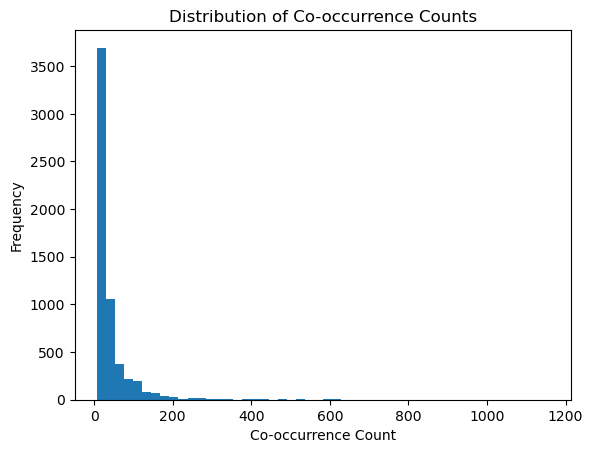

In [212]:
import matplotlib.pyplot as plt

plt.hist(edge_weight.numpy(), bins=50)
plt.title("Distribution of Co-occurrence Counts")
plt.xlabel("Co-occurrence Count")
plt.ylabel("Frequency")
plt.show()


In [213]:
max_weight = edge_weight.max()
min_weight = edge_weight.min()
avg_weight = edge_weight.mean()
# Assume edge_weight contains all co-occurrence counts
print(f"Max weight: {max_weight}, Min weight: {min_weight}, Average weight: {avg_weight}")

# log-transform the edge weights
edge_weight = edge_weight.log1p()
edge_weight


Max weight: 1156.0, Min weight: 8.0, Average weight: 40.788883209228516


tensor([2.4849, 5.2364, 3.5835,  ..., 2.3026, 2.3026, 2.3026])

In [214]:
# After Normalizing the edge weights
max_weight = edge_weight.max()
min_weight = edge_weight.min()
avg_weight = edge_weight.mean()
print(f"Max weight: {max_weight}, Min weight: {min_weight}, Average weight: {avg_weight}")

Max weight: 7.053585529327393, Min weight: 2.1972246170043945, Average weight: 3.2697150707244873


In [215]:
# min-max normalization
edge_weight = (edge_weight - min_weight) / (max_weight - min_weight)
edge_weight

tensor([0.0592, 0.6258, 0.2855,  ..., 0.0217, 0.0217, 0.0217])

In [216]:
max_weight = edge_weight.max()
min_weight = edge_weight.min()
avg_weight = edge_weight.mean()
print(f"Max weight: {max_weight}, Min weight: {min_weight}, Average weight: {avg_weight}")

Max weight: 1.0, Min weight: 0.0, Average weight: 0.2208423912525177


In [217]:
# Create node features (optional: identity matrix for simple embeddings)
node_features = torch.eye(num_ingredients)
node_features

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [218]:
graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight)
# save the graph
torch.save(graph, 'ingredient_graph.pt')


In [219]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_cooccurrence_graph(graph, ingredient_names=None):
    """
    Visualize the co-occurrence graph using NetworkX.

    Parameters:
    - graph: PyTorch Geometric Data object representing the graph.
    - ingredient_names: List of ingredient names for labeling nodes (optional).
    """
    # Convert PyTorch Geometric graph to NetworkX graph
    nx_graph = to_networkx(graph, edge_attrs=['edge_attr'], to_undirected=True)

    # Set node labels
    if ingredient_names:
        labels = {i: ingredient_names[i] for i in range(len(ingredient_names))}
    else:
        labels = {i: str(i) for i in range(graph.num_nodes)}

    # Extract edge weights for visualizing edge thickness
    edge_weights = nx.get_edge_attributes(nx_graph, 'edge_attr')

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(nx_graph, seed=42)  # Use a force-directed layout
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        labels=labels,
        node_color='lightblue',
        node_size=500,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        width=[weight / max(edge_weights.values()) * 5 for weight in edge_weights.values()]  # Scale edge thickness
    )
    plt.title("Ingredient Co-occurrence Graph")
    plt.show()

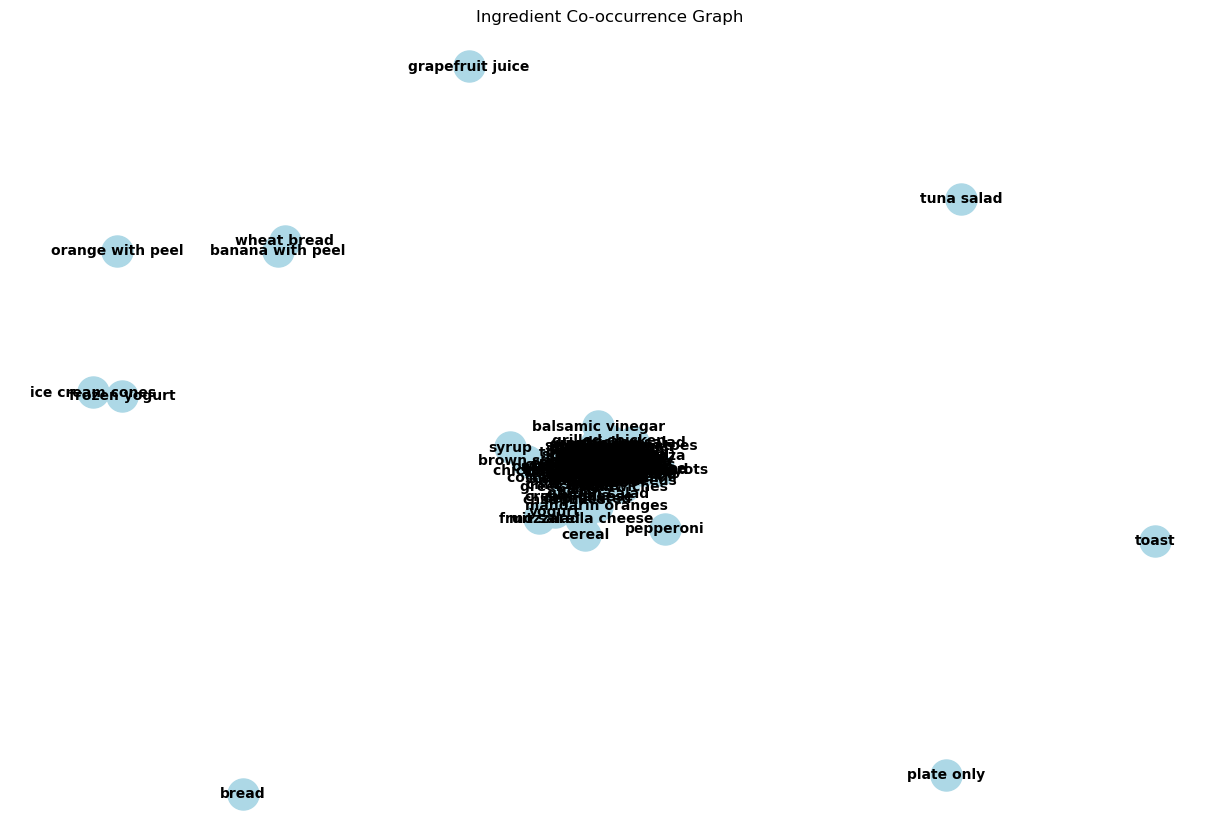

In [220]:
# Create the co-occurrence graph
ingredient_graph = create_ingredient_graph(ingr_list, num_ingredients)

# Optionally, load or define ingredient names (e.g., from a CSV or predefined list)
ingredient_names = df.columns[1:-1].tolist()  # Assuming ingredient names are in the columns

# Visualize the graph
visualize_cooccurrence_graph(ingredient_graph, ingredient_names=ingredient_names)
